# Imports

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Params

In [ ]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRAINING_SPLIT = 0.8

# Load data

In [16]:
data_dir = "data/bbc-text.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape: {data.shape}")
print(f"{data[:5]}]")

Shape: (2225, 2)
[['tech'
  'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are

# Train/Validation split

In [19]:
def train_val_datasets(data):
    train_size = round(len(data)*TRAINING_SPLIT)
    texts = data[:,1]
    labels = data[:,0]

    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]

    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))

    return train_dataset, validation_dataset

In [21]:
train_dataset, validation_dataset = train_val_datasets(data)

In [22]:
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

There are 1780 sentence-label pairs for training.

There are 445 sentence-label pairs for validation.



# Vectorization and Padding

In [28]:
def standardize_func(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]
    sentence = tf.strings.lower(sentence)
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    
    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")


    return sentence    

In [29]:
def fit_vectorizer(train_sentences, standardize_func):
    vectorizer = tf.keras.layers.TextVectorization(
        standardize=standardize_func,
        max_tokens=VOCAB_SIZE,
        output_sequence_length=MAX_LENGTH
    )

    vectorizer.adapt(train_sentences)

    return vectorizer

In [30]:
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 1000 words



2025-03-18 17:40:09.662116: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
def fit_label_encoder(train_labels, validation_labels):
    labels = train_labels.concatenate(validation_labels)

    label_encoder = tf.keras.layers.StringLookup(num_oov_indices=0)

    label_encoder.adapt(labels)

    return label_encoder

In [33]:
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
                                  
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Unique labels: ['sport', 'business', 'politics', 'tech', 'entertainment']


2025-03-18 17:43:01.031563: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Preprocess data

In [36]:
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    dataset = dataset.map(lambda text, label: (text_vectorizer(text), label_encoder(label)))
    dataset = dataset.batch(32)

    return dataset

In [37]:
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

print(f"Number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"Number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

Number of batches in the train dataset: 56
Number of batches in the validation dataset: 14


In [38]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


# Create the model

In [44]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model
    

In [45]:
model = create_model()

In [46]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)


Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.2572 - loss: 1.6013 - val_accuracy: 0.4090 - val_loss: 1.5640
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4334 - loss: 1.5362 - val_accuracy: 0.5056 - val_loss: 1.4519
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5640 - loss: 1.3939 - val_accuracy: 0.7506 - val_loss: 1.2525
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.7600 - loss: 1.1651 - val_accuracy: 0.8494 - val_loss: 1.0025
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8753 - loss: 0.9002 - val_accuracy: 0.8876 - val_loss: 0.7681
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.9304 - loss: 0.6662 - val_accuracy: 0.9056 - val_loss: 0.5904
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9484 - loss: 0.4944 - val_accuracy: 0.9213 - val_loss: 0.4653
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9560 - loss: 0.3736 - val_accuracy: 0.9258 - v

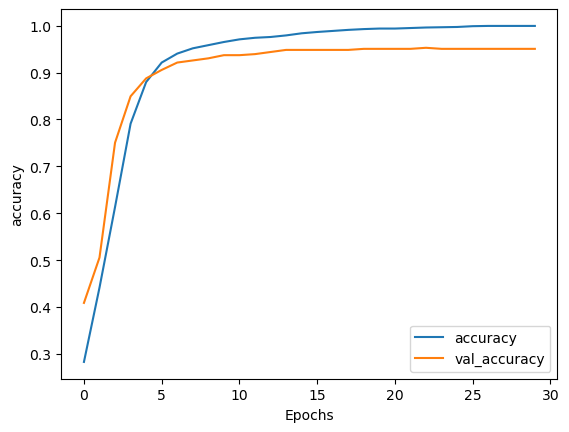

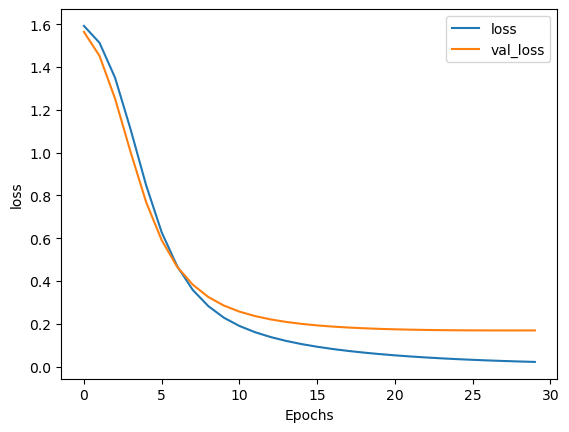

In [47]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")